# Background and goals

This notebook tests whether we can decrease the length of *Caenorhabditis elegans* videos without reducing the information we capture about motility phenotypes.
We do this by using autocorrelation. 
Autocorrelation is a statistical measure used to assess the degree of similarity between a given time series and a lagged version of itself over successive time intervals.
Here, our time intervals are frames.
In this context, autocorrelation helps us understand the temporal dependencies in the behavioral data of C. elegans.
By identifying where the autocorrelation becomes significant, we can determine the frame at which the data starts to provide redundant information about the worm's behavior.

Tierpsy Tracker produced the behavior data we're working with.
Tierpsy Tracker is a video analysis software that tracks and quantifies the movement and behavior of *C. elegans*.
We're working with the *features* file it generates, which reports ~140 variables related to the organism's motility and other behaviors.

Our current videos are 30 seconds long captured at 24.5 frames per second (735 frames per video).
In the videos we analyzed in this notebook, the worms all exited the field of view before 30 seconds, so we captured fewer frames per worm.

This analysis is similar to an autocorrelation analysis performed at Arcadia for chlammy data (see [here](https://research.arcadiascience.com/pub/result-chlamydomonas-phenotypes#nlrkl0jlnh5)).
In that analysis, Arcadians found that chlammy motility (velocity, angular velocity) was autocorrelated at about 5 seconds.
Given this, in subsequent analyses we filter at to a minimum of 10 second trajectories.

## Notebook set up

In [1]:
setwd("..")

In [39]:
# adjust plot size rendered inline
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 200)

In [40]:
library(tidyverse)
library(rhdf5)
library(arcadiathemeR)
source("scripts/utils.R")

## Look at autocorrelation for one variable in one video

Below we see an autocorrelation plot for the variable "speed" from the 13th feild of view that we captured for wildtype (ND2) worms about ~1 hour after being transferred to a plate (no OP50).
In most time series, it's common for there to be an initial period of autocorrelation between the series is no longer correlated.
On the plot, we marked the first point where the time series returns to autocorrelation.
For this sample, this occurs at 62 frames (2.5 seconds).

In [5]:
hdf5_files_1hr_13 <- Sys.glob("tmp/2024-07-25-1hr-unprocessed/N2_1h_013_featuresN.hdf5")
tierpsy_1hr_13 <- process_hdf5_files(hdf5_files_1hr_13, required_frames = 100) %>% parse_file_id(type = "filename")
tierpsy_1hr_13_filtered <- filter_incomplete_tierpsy_observations(tierpsy_1hr_13)
tierpsy_1hr_13_longest <- find_longest_frame_stretch_df(tierpsy_1hr_13_filtered)

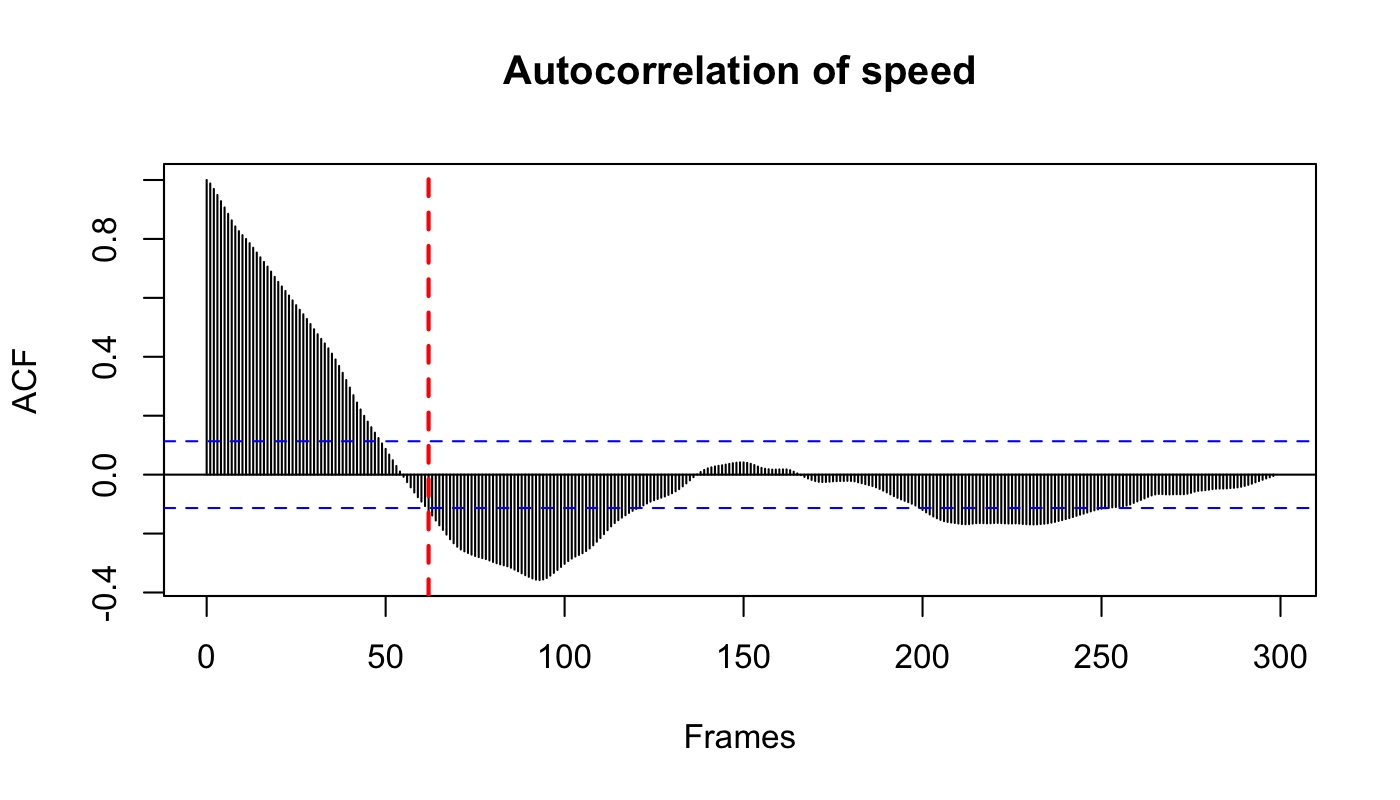

In [43]:
acf(tierpsy_1hr_13_longest$speed, lag.max = nrow(tierpsy_1hr_13_longest), xlab = "Frames", main = "Autocorrelation of speed")
first_significant <- find_first_significant_acf(tierpsy_1hr_13_longest$speed)
abline(v = first_significant, col = "red", lwd = 2, lty = 2)

In [7]:
# Function to calculate the first time ACF is significant after falling below the significance line once
# Most time series are highly correlated for the first few frames.
# We don't care about this, we care about when it's correlated again.
find_first_significant_acf <- function(tierpsy_column) {
  acf_result <- acf(tierpsy_column, plot = FALSE, lag.max = length(tierpsy_column), xlab = "Frames")
  acf_values <- acf_result$acf[-1]  # exclude the lag 0
  conf_int <- qnorm((1 + 0.95) / 2) / sqrt(length(tierpsy_column))
  
  below_conf_int <- which(abs(acf_values) < conf_int)
  if (length(below_conf_int) == 0) {
    return(NA)
  }
  
  first_below <- below_conf_int[1]
  first_above_after_below <- which(abs(acf_values[(first_below+1):length(acf_values)]) >= conf_int)
  
  if (length(first_above_after_below) == 0) {
    return(NA)
  }
  
  return(first_above_after_below[1] + first_below)
}

## Apply to all worm images for which we got good data

Below, we apply the same autocorrelation analysis to the four worm videos with good data (the worms are motile and do not feed on a stray bacterial chunk that was accidentally transferred).
We then plot the equivalent of the red dashed line shown in the plot above for each worm for each measured variable.

In [8]:
hdf5_files <- Sys.glob("tmp/2024-07-25-1hr-unprocessed/*featuresN.hdf5")

all_acf_significance_results <- list()

for (file in hdf5_files) {
  tierpsy_data <- process_hdf5_files(file, required_frames = 100) %>% parse_file_id(type = "filename")
  tierpsy_data_filtered <- filter_incomplete_tierpsy_observations(tierpsy_data)
  tierpsy_data_longest <- find_longest_frame_stretch_df(tierpsy_data_filtered)
  
  variable_names <- names(tierpsy_data_longest)
  variable_names <- variable_names[!variable_names %in% c("file_id", "worm_index", "timestamp")]
  
  acf_significance_results <- list()
  
  for (var_name in variable_names) {
    if (is.numeric(tierpsy_data_longest[[var_name]])) {
      acf_significance_results[[var_name]] <- find_first_significant_acf(tierpsy_data_longest[[var_name]])
    }
  }
  
  all_acf_significance_results[[file]] <- acf_significance_results
}

In [13]:
results_list <- list()
for (file in names(all_acf_significance_results)) {
  acf_df <- enframe(all_acf_significance_results[[file]], name = "variable", value = "first_significant_acf_after_below")
  acf_df$file <- basename(file)
  acf_df$first_significant_acf_after_below <- unlist(acf_df$first_significant_acf_after_below)
  results_list[[file]] <- acf_df
}

acf_significance_df <- bind_rows(results_list) %>%
  arrange(desc(first_significant_acf_after_below)) %>%
  mutate(file = str_remove(string = file, pattern = "_featuresN.hdf5"))

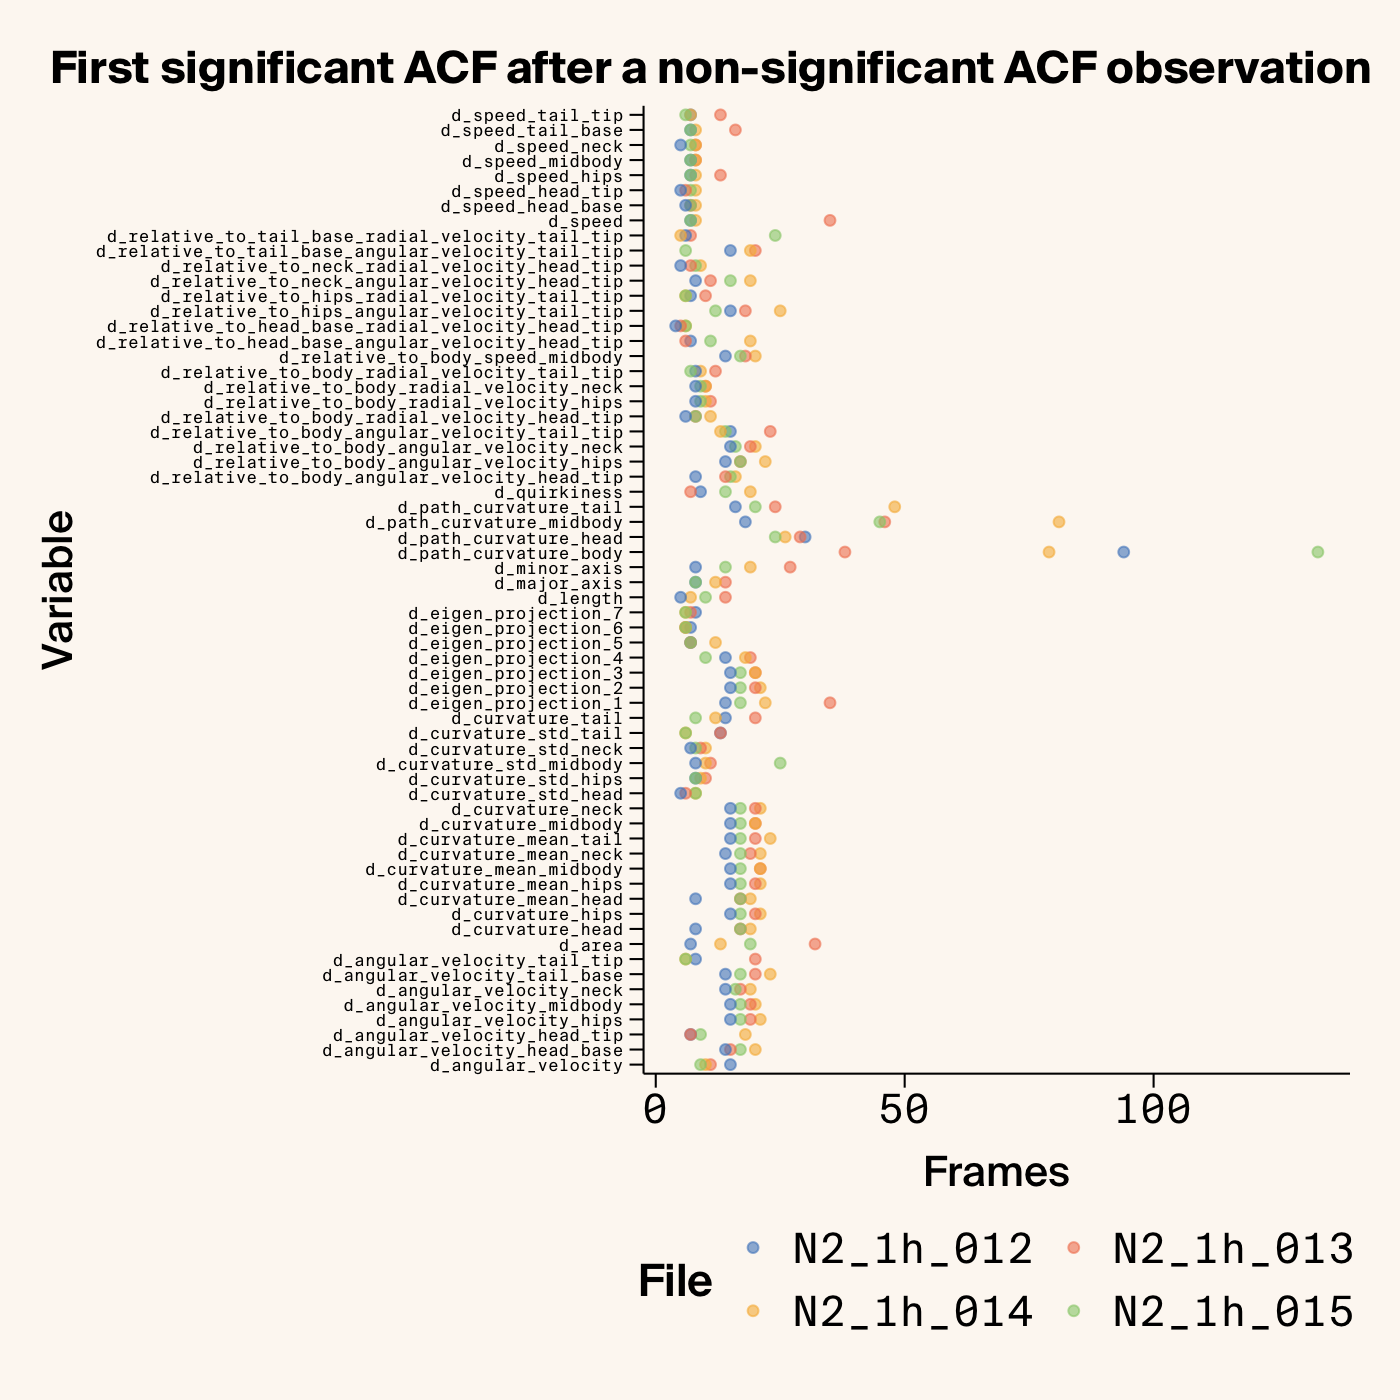

In [35]:
options(repr.plot.width = 7, repr.plot.height = 7, repr.plot.res = 200)

ggplot(acf_significance_df %>% filter(str_detect(pattern = "^d_", string = variable)), 
       aes(x = variable, y = first_significant_acf_after_below, color = file)) +
  geom_point(alpha = 0.6) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "First significant ACF after a non-significant ACF observation",
       x = "Variable",
       y = "Frames",
       color = "File") +
  theme_arcadia() +
  scale_color_arcadia() +
  coord_flip() +
  theme(axis.text.y = element_text(size = 6),
        plot.title.position = "plot",
        legend.position = "bottom") +
  guides(color = guide_legend(nrow = 2, byrow = TRUE))

Warning message:
“Removed 7 rows containing missing values or values outside the scale range (`geom_point()`).”


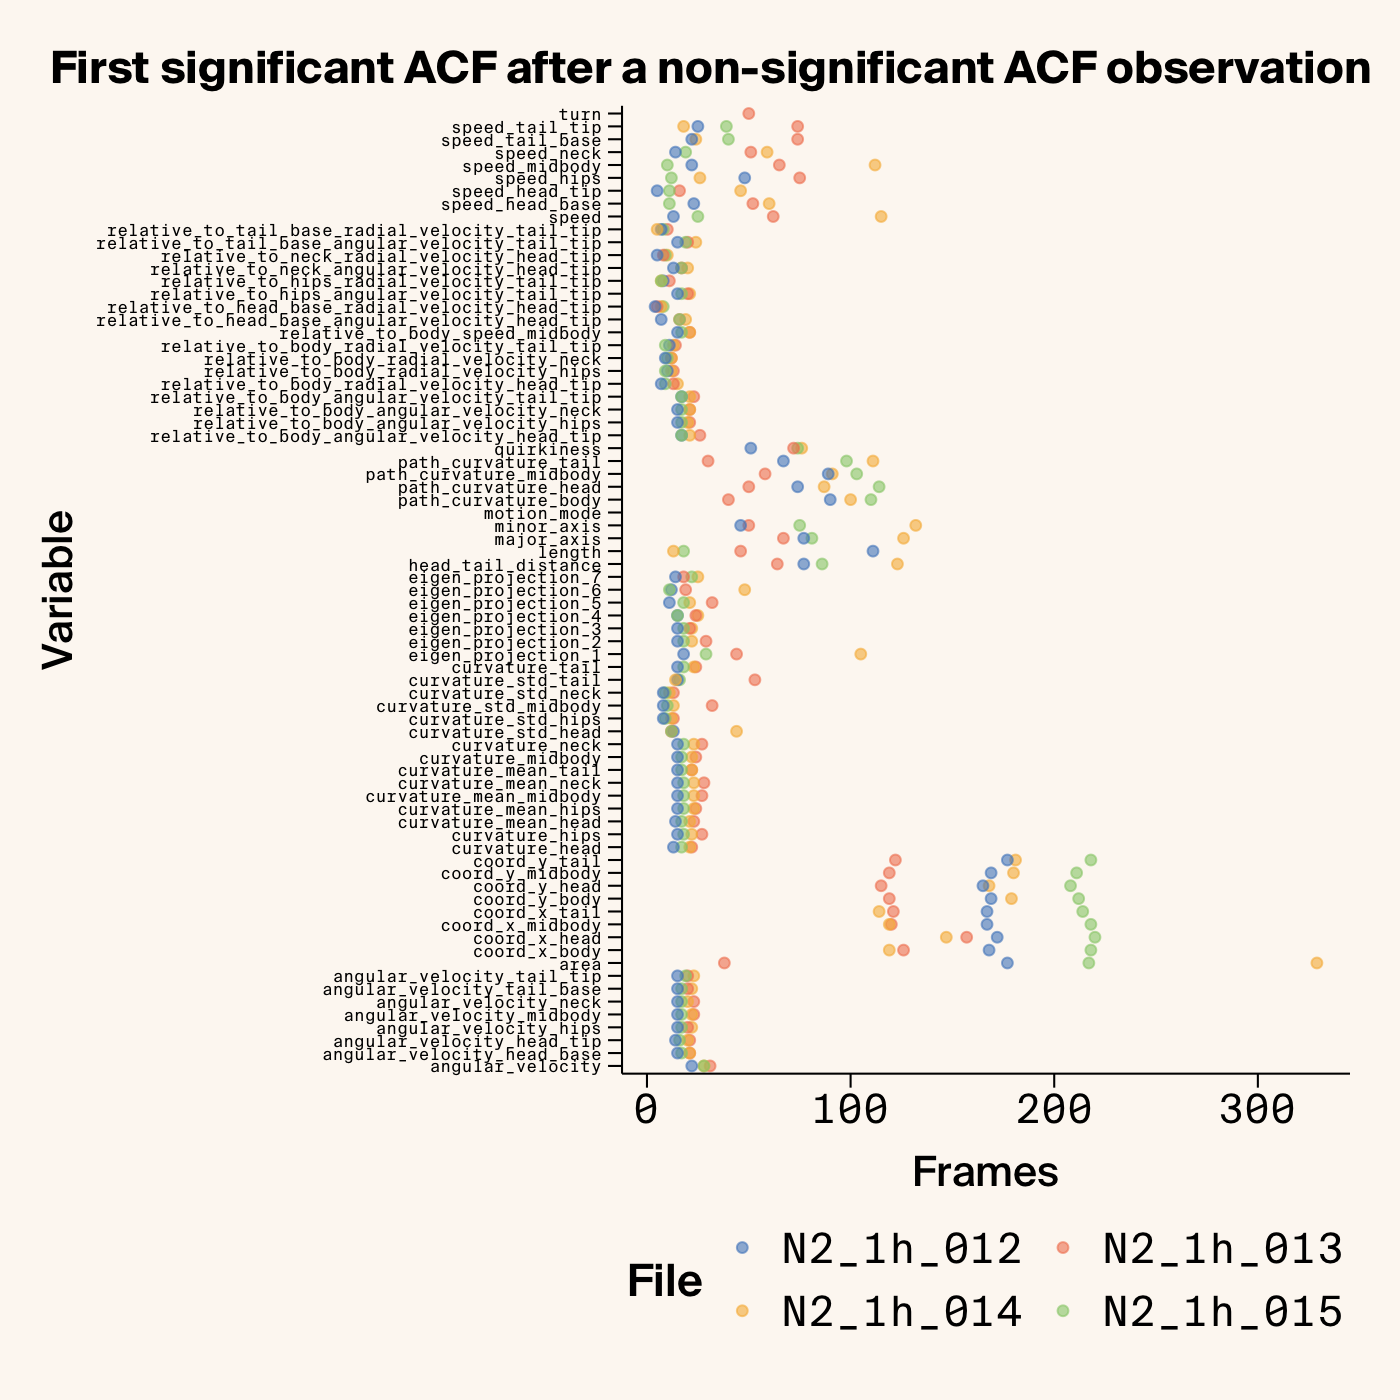

In [36]:
ggplot(acf_significance_df %>% filter(!str_detect(pattern = "^d_", string = variable)), 
       aes(x = variable, y = first_significant_acf_after_below, color = file)) +
  geom_point(alpha = 0.6) +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(title = "First significant ACF after a non-significant ACF observation",
       x = "Variable",
       y = "Frames",
       color = "File") +
  theme_arcadia() +
  coord_flip() +
  theme(axis.text.y = element_text(size = 6),
        plot.title.position = "plot",
        legend.position = "bottom") +
  scale_color_arcadia() +
  guides(color = guide_legend(nrow = 2, byrow = TRUE))

## Conclusion

For this data, most metrics are autocorrelated by 150 frames (6 seconds) (not shown—there is a 7-frame lag period between when the video begins and when there is enough data to report metrics, so this would actually be 6.5 seconds).
For a handful of metrics—area, and metrics from the worms' coordinates in the field of view—it takes more frames to reach autocorrelation, around 220. 
These metrics don't make as much sense when calculating autocorrelation, so I think they can be ignored.
However, if we include them, we'd need to capture 227-336 frames (9.2 - 13.7 seconds).
Given this, I think we could safely reduce our video length to 10-15 seconds.

In [44]:
sessionInfo()

R version 4.3.3 (2024-02-29)
Platform: x86_64-apple-darwin13.4.0 (64-bit)
Running under: macOS Big Sur ... 10.16

Matrix products: default
BLAS/LAPACK: /Users/taylorreiter/miniconda3/envs/wormmotility/lib/libopenblasp-r0.3.27.dylib;  LAPACK version 3.12.0

locale:
[1] en_US.UTF-8/en_US.UTF-8/en_US.UTF-8/C/en_US.UTF-8/en_US.UTF-8

time zone: America/New_York
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] arcadiathemeR_0.1.0 rhdf5_2.46.1        lubridate_1.9.3    
 [4] forcats_1.0.0       stringr_1.5.1       dplyr_1.1.4        
 [7] purrr_1.0.2         readr_2.1.5         tidyr_1.3.1        
[10] tibble_3.2.1        ggplot2_3.5.1       tidyverse_2.0.0    

loaded via a namespace (and not attached):
 [1] gtable_0.3.5        jsonlite_1.8.8      compiler_4.3.3     
 [4] crayon_1.5.3        tidyselect_1.2.1    IRdisplay_1.1      
 [7] rhdf5filters_1.14.1 snakecase_0.11.1    scales_1.3.0